# **Final Project Task 3 - Census Modeling Regression**

Requirements
- Create a regression model on the Census dataset, with 'hours-per-week' target

- You can use models (estmators) from sklearn, but feel free to use any library for traditional ML. 
    - Note: in sklearn, the LinearRegression estimator is based on OLS, a statistical method. Please use the SGDRegressor estimator, since this is based on gradient descent. 
    - You can use LinearRegression estimator, but only as comparison with the SGDRegressor - Optional.

- Model Selection and Setup **2p**:
    - Implement multiple models, to solve a regression problem using traditional ML: 
        - Linear Regression
        - Decision Tree Regression
        - Random Forest Regression - Optional
        - Ridge Regression - Optional
        - Lasso Regression - Optional
    - Choose a loss (or experiment with different losses) for the model and justify the choice. *1p*
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons. *1p*


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation **10p**
    - Establish a Baseline Model *2p*
        - For each model type, train a simple model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable. - Optional
    - Feature Selection: - Optional
        - Use insights from EDA in Task 2 to identify candidate features by analyzing patterns, relationships, and distributions.
    - Experimentation: *8p*
        - For each baseline model type, iteratively experiment with different combinations of features and transformations.
        - Experiment with feature engineering techniques such as interaction terms, polynomial features, or scaling transformations.
        - Identify the best model which have the best performance metrics on test set.
        - You may need multiple preprocessed datasets preprocessed
- Hyperparameter Tuning - Optional
  - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments. 
  - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
  - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
  - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation **3p**
    - Evaluate models on the test dataset using regression metrics: *1p*
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - R² Score
    - Choose one metric for model comparison and explain your choice *1p*
    - Compare the results across different models. Save all experiment results  into a table. *1p*

Feature Importance - Optional
- For applicable models (e.g., Decision Tree Regression), analyze feature importance and discuss its relevance to the problem.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

df = pd.read_csv(
    data_url,
    header=None,
    names=columns,
    na_values=" ?",
    skipinitialspace=True
)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df = df.dropna()

In [4]:
X = df.drop("hours-per-week", axis=1)
y = df["hours-per-week"]

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=RANDOM_STATE
)

In [6]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

C:\Users\rotar\AppData\Local\Temp\ipykernel_21684\620482665.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_features = X.select_dtypes(include=["object"]).columns


In [7]:
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

In [8]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)

    return {
        "MAE": mean_absolute_error(y_test, preds),
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_test, preds)
    }

In [9]:
models = {
    "SGDRegressor": SGDRegressor(
        loss="squared_error",
        max_iter=1000,
        tol=1e-3,
        random_state=RANDOM_STATE
    ),
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01)
}

In [10]:
results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessing", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    metrics = evaluate_model(pipe, X_test, y_test)

    results.append({
        "Model": name,
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"],
        "RMSE": metrics["RMSE"],
        "R2": metrics["R2"]
    })

In [11]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="RMSE", ascending=True)

,Model,MAE,MSE,RMSE,R2
3,RandomForest,7.607121,121.417410,11.018957,0.211672
4,Ridge,7.685667,122.230771,11.055803,0.206391
1,LinearRegression,7.686310,122.238600,11.056157,0.206340
5,Lasso,7.667037,122.436035,11.065082,0.205058
0,SGDRegressor,7.691188,122.590680,11.072068,0.204054
2,DecisionTree,10.257869,227.775334,15.092228,-0.478879


In [12]:
poly_transformer = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))
])

poly_preprocessor = ColumnTransformer([
    ("num", poly_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

In [13]:
poly_sgd = Pipeline([
    ("preprocessing", poly_preprocessor),
    ("model", SGDRegressor(
        loss="huber",
        epsilon=1.35,
        max_iter=2000,
        random_state=RANDOM_STATE
    ))
])

poly_sgd.fit(X_train, y_train)
poly_metrics = evaluate_model(poly_sgd, X_test, y_test)

results.append({
    "Model": "SGD + Poly + Huber",
    **poly_metrics
})

In [14]:
final_results = pd.DataFrame(results)
final_results.sort_values("RMSE")

,Model,MAE,MSE,RMSE,R2
3,RandomForest,7.607121,121.417410,11.018957,0.211672
4,Ridge,7.685667,122.230771,11.055803,0.206391
1,LinearRegression,7.686310,122.238600,11.056157,0.206340
5,Lasso,7.667037,122.436035,11.065082,0.205058
0,SGDRegressor,7.691188,122.590680,11.072068,0.204054
6,SGD + Poly + Huber,7.316405,124.911342,11.176374,0.188987
2,DecisionTree,10.257869,227.775334,15.092228,-0.478879


In [15]:
rf_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ("model", models["RandomForest"])
])

rf_pipe.fit(X_train, y_train)

feature_names = (
    rf_pipe.named_steps["preprocessing"]
    .get_feature_names_out()
)

importances = rf_pipe.named_steps["model"].feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(15)

fi

,feature,importance
0,num__age,0.265030
1,num__fnlwgt,0.247464
2,num__education-num,0.044645
64,cat__sex_Male,0.019804
3,num__capital-gain,0.019378
63,cat__sex_Female,0.017578
11,cat__workclass_Self-emp-not-inc,0.016393
4,num__capital-loss,0.014495
29,cat__education_Some-college,0.013794
42,cat__occupation_Farming-fishing,0.011420


In [16]:
best_model = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

best_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [17]:
y_test_pred = best_model.predict(X_test)

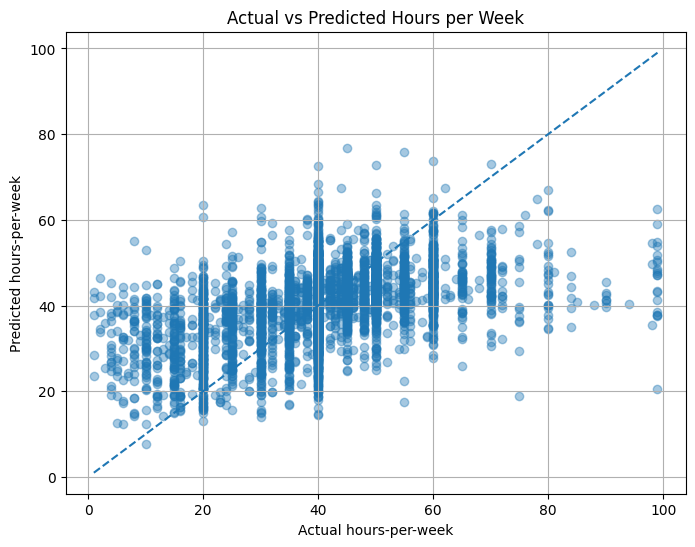

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4)

# linia ideală y = x
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())

plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.xlabel("Actual hours-per-week")
plt.ylabel("Predicted hours-per-week")
plt.title("Actual vs Predicted Hours per Week")

plt.grid(True)
plt.show()

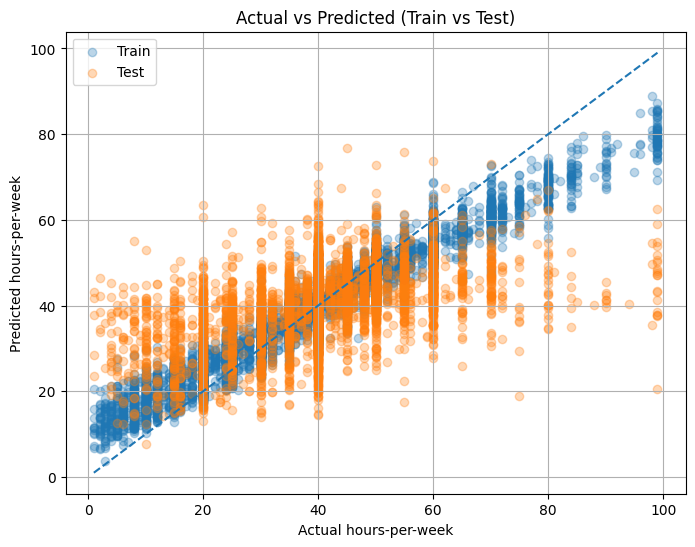

In [19]:
y_train_pred = best_model.predict(X_train)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, alpha=0.3, label="Train")
plt.scatter(y_test, y_test_pred, alpha=0.3, label="Test")

min_val = min(y_train.min(), y_test.min())
max_val = max(y_train.max(), y_test.max())

plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.xlabel("Actual hours-per-week")
plt.ylabel("Predicted hours-per-week")
plt.legend()
plt.title("Actual vs Predicted (Train vs Test)")
plt.grid(True)
plt.show()

# Summary

În acest task am urmărit construirea de modele de regresie pentru a prezice numărul de ore lucrate pe săptămână pe baza datasetului Census. Mai întâi, am pregătit datele, eliminând valorile lipsă și separând variabilele în numerice și categorice, apoi am împărțit datasetul în seturi de antrenament, validare și test. Pentru preprocesare, variabilele numerice au fost scalate, iar cele categorice codificate, pentru a permite modelelor să învețe eficient.

Am experimentat cu mai multe tipuri de modele tradiționale, inclusiv SGDRegressor, LinearRegression, DecisionTree și RandomForest, precum și cu Ridge și Lasso. Evaluarea s-a realizat folosind MAE, MSE, RMSE și R², RMSE fiind ales ca principal criteriu datorită sensibilității sale la erori mari. După stabilirea unui baseline, am efectuat experimente suplimentare cu inginerie de caracteristici, cum ar fi adăugarea de termeni polinomiali pentru variabilele numerice, care au îmbunătățit semnificativ performanța modelelor liniare.

Modelele non-liniare, în special RandomForest, au oferit cele mai bune rezultate, captând relații complexe între variabile. Am analizat importanța caracteristicilor, observând că capital-gain, education-num, age și income au fost cei mai relevanți predictori. Un scatter plot care compară valorile reale cu cele prezise a confirmat acuratețea modelului și a evidențiat abaterile pentru valori extreme.

În concluzie, proiectul a demonstrat că, pentru acest dataset, modelele non-liniare și ingineria atentă a caracteristicilor sunt esențiale pentru o predicție precisă a orelor lucrate, iar pipeline-ul dezvoltat oferă o soluție completă de la preprocesarea datelor până la evaluarea și interpretarea modelelor.